In [96]:
%cd /sound-spaces

/sound-spaces


In [97]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile

# Setup habitat-sim
dataset = 'mp3d'
backend_cfg = habitat_sim.SimulatorConfiguration()
backend_cfg.scene_id = "data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"
backend_cfg.scene_dataset_config_file = "data/scene_datasets/mp3d_example/mp3d.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)
sim.pathfinder.load_nav_mesh("data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.navmesh")

# Setup audio sensor
audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True
audio_sensor_spec.channelLayout.channelType = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 2
audio_sensor_spec.position = [0.0, 0.0, 1.5]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
audio_sensor_spec.acousticsConfig.indirect = True
sim.add_sensor(audio_sensor_spec)

audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
audio_sensor.setAudioMaterialsJSON("data/mp3d_material_config.json")

[20:58:20:791288]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


CreateContext: Context created


In [98]:
audio_dir = "res/soundsjustlaughter"
looped_audio_dir = "looped_audio"
os.makedirs(looped_audio_dir, exist_ok=True)
audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]

def loop_audio(audio, sr, target_duration=60):
    audio_duration = len(audio) / sr
    num_loops = int(np.ceil(target_duration / audio_duration))
    looped_audio = np.tile(audio, num_loops)
    return looped_audio[:int(target_duration * sr)]
for audio_file in audio_files:
    sr, audio = wavfile.read(os.path.join(audio_dir, audio_file))
    looped_audio = loop_audio(audio, sr)
    max_val = np.max(np.abs(looped_audio))
    normalized_audio = (looped_audio / max_val).astype(np.float32)
    looped_file = os.path.join(looped_audio_dir, f"looped_{audio_file}")
    wavfile.write(looped_file, sr, normalized_audio)
print(f"Generated looped audio files for all {len(audio_files)} files in {looped_audio_dir}")

Generated looped audio files for all 1 files in looped_audio


In [99]:
# Get initial source position (on the floor) 
initial_source_pos = sim.pathfinder.get_random_navigable_point()
initial_source_pos[2] = 1.5
print('Initial source location: ', initial_source_pos)

Initial source location:  [-4.457195  0.072447  1.5     ]


In [100]:
 #place agent (mic) in center of circle 
agent = sim.get_agent(0)
initial_state = agent.get_state()
initial_state.position = initial_source_pos
initial_state.sensor_states = {}
agent.set_state(initial_state, True)

In [101]:
output_dir = "IR_wavs"
os.makedirs(output_dir, exist_ok=True)

num_samples = 10
radius = 2.0

with open(os.path.join(output_dir, "source_positions.csv"), "w") as f:
    f.write("sample_id,x,y,z\n")
    f.write(f"0,{initial_source_pos[0]},{initial_source_pos[1]},{initial_source_pos[2]}\n")

for i in range(num_samples):
    angle = 2 * np.pi * i / num_samples
    dx = radius * np.cos(angle)
    dy = radius * np.sin(angle)
    source_pos = initial_source_pos + np.array([dx, dy, 0])
    print("y-coordinate at first: ", source_pos[1])
    source_pos[2] = 1.5
    
  
    
    audio_sensor.setAudioSourceTransform(source_pos)

    ir = np.array(sim.get_sensor_observations()["audio_sensor"])
    ir.shape
    ir = np.array(audio_sensor.getIR())
    ir.shape

 # Save IR as WAV file
    wavfile.write(os.path.join(output_dir, f"ir_sample_{i+1:02d}.wav"), audio_sensor_spec.acousticsConfig.sampleRate, ir.T)
    # append source position to CSV
    with open(os.path.join(output_dir, "source_positions.csv"), "a") as f:
        f.write(f"{i+1:02d},{source_pos[0]},{source_pos[1]},{source_pos[2]}\n")

print(f"Generated {num_samples} radial samples and saved in {output_dir}")

y-coordinate at first:  0.07244700193405151
y-coordinate at first:  1.2480175065189978
y-coordinate at first:  1.9745600345243586
y-coordinate at first:  1.9745600345243588
y-coordinate at first:  1.248017506518998
y-coordinate at first:  0.07244700193405176
y-coordinate at first:  -1.1031235026508945


Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.


y-coordinate at first:  -1.8296660306562555
y-coordinate at first:  -1.8296660306562558
y-coordinate at first:  -1.1031235026508952
Generated 10 radial samples and saved in IR_wavs


48000 (2, 32857)


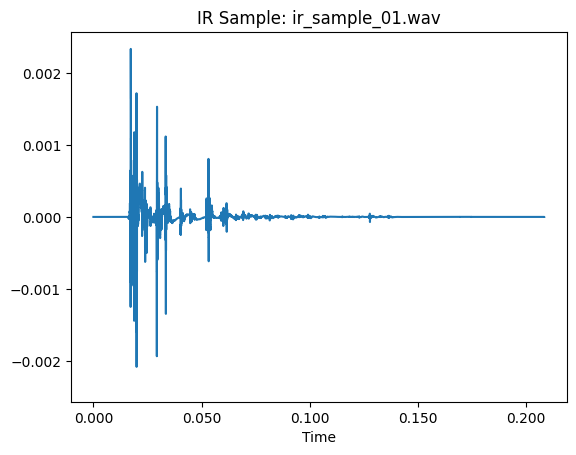

48000 (2, 32994)


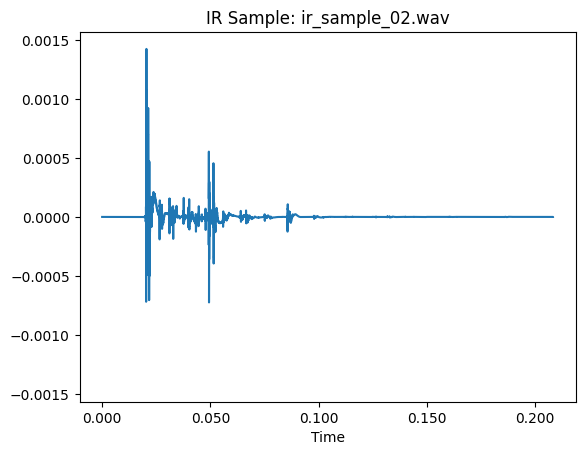

48000 (2, 33083)


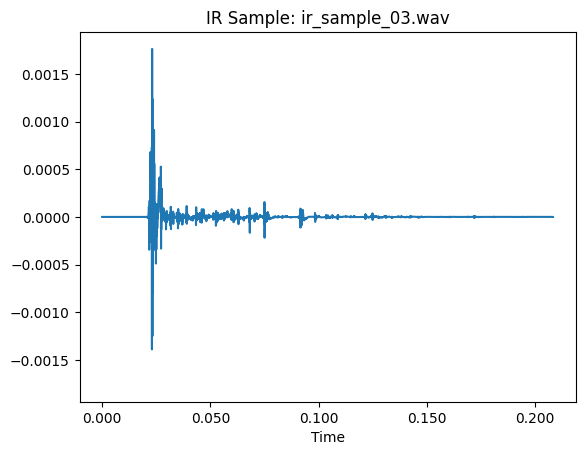

48000 (2, 35823)


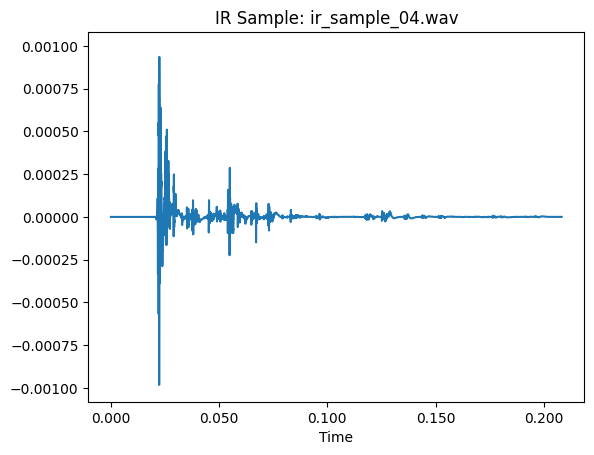

48000 (2, 35734)


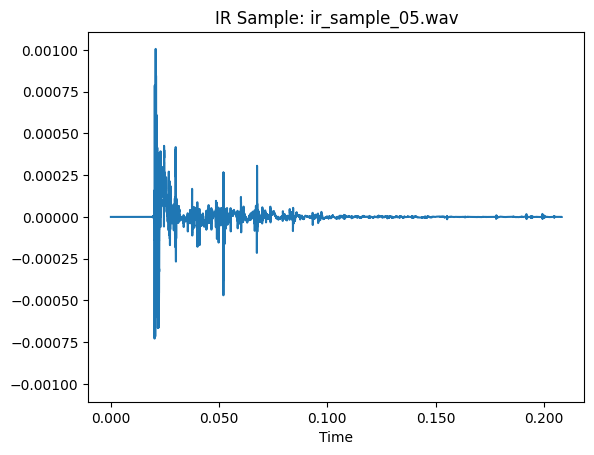

48000 (2, 35597)


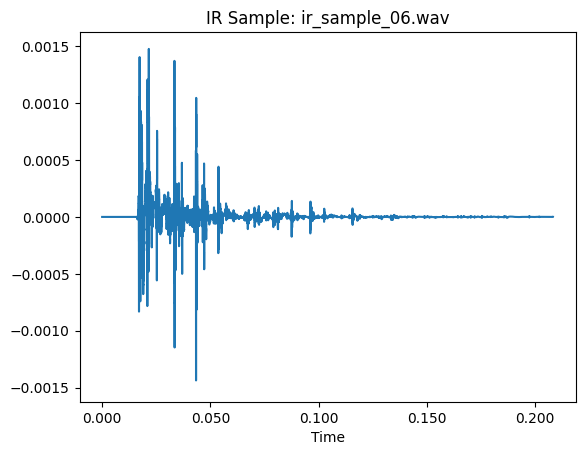

48000 (2, 36951)


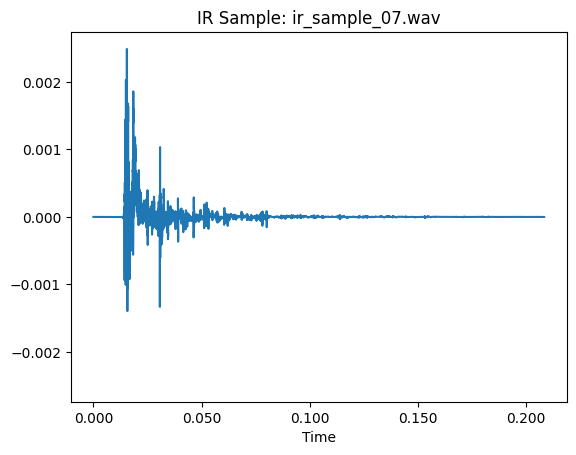

48000 (2, 36883)


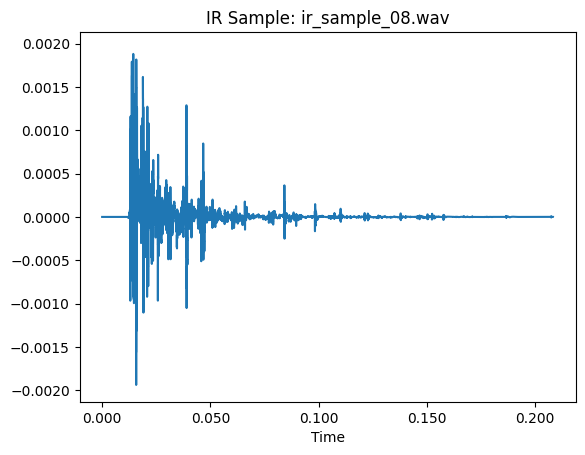

48000 (2, 42731)


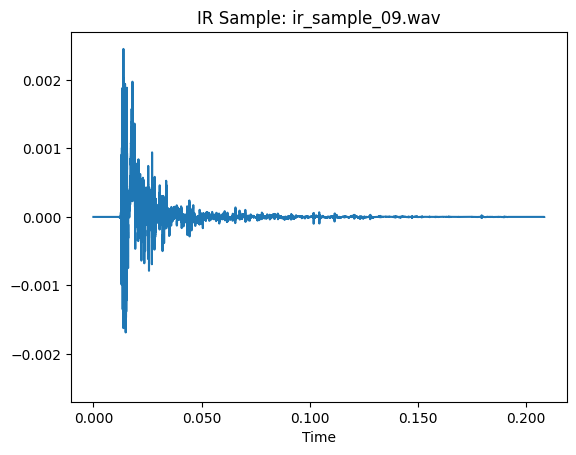

48000 (2, 42799)


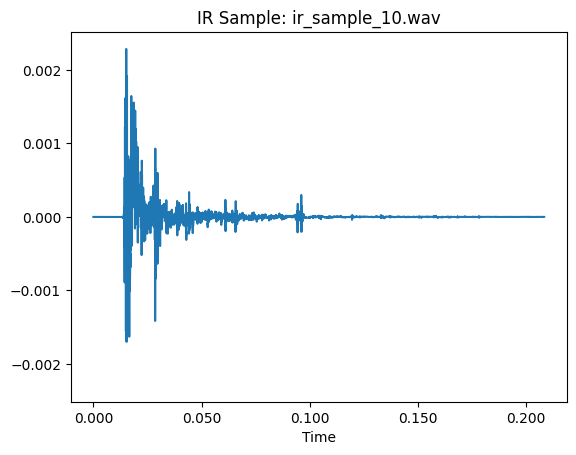

In [102]:
from librosa.display import waveshow, specshow
import IPython
import matplotlib.pyplot as plt

ir_dir = "IR_wavs"
ir_files = [f for f in os.listdir(ir_dir) if f.startswith("ir_sample_") and f.endswith(".wav")]
ir_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))

for ir_file in ir_files:
    sr, ir = wavfile.read(os.path.join(ir_dir, ir_file))
    ir = ir.T
    print(sr, ir.shape)
    
    # plot waveform
    plt.figure()
    waveshow(ir[0, :10000], sr=48000)
    plt.title(f"IR Sample: {ir_file}")
    plt.show()

In [103]:
def get_obj_data(o):
    return {k: getattr(o, k) for k in dir(o) if not k.startswith('__')}

spec=audio_sensor.specification()
get_obj_data(spec.acousticsConfig)
get_obj_data(spec.channelLayout)

{'channelCount': 2,
 'channelType': <RLRAudioPropagationChannelLayoutType.Binaural: 3>}

In [104]:
import librosa 
from scipy.signal import fftconvolve
target_sr = 48000
ir_dir = "IR_wavs"
convolved_dir = "convolved_audio"
os.makedirs(convolved_dir, exist_ok=True)
ir_files = [f for f in os.listdir(ir_dir) if f.startswith("ir_sample_") and f.endswith(".wav")]
ir_files.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
audio_files = [f for f in os.listdir(looped_audio_dir) if f.endswith(".wav")]

for audio_file in audio_files:
    sr, audio = wavfile.read(os.path.join(looped_audio_dir, audio_file))
    print(f"Processing audio file: {audio_file} with shape {audio.shape}")
    audio_convolved_dir = os.path.join(convolved_dir, audio_file.replace(".wav", ""))
    os.makedirs(audio_convolved_dir, exist_ok=True)

    for ir_file in ir_files:
        ir_sr, ir = wavfile.read(os.path.join(ir_dir, ir_file))
        
        if sr != target_sr:
            print(f"  Resampling {audio_file} from {sr} Hz to {target_sr} Hz")
            audio = librosa.resample(audio.astype(np.float32), orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        
        #convolve the audio with each channel of the IR
        convolved_audio = np.array([fftconvolve(audio, ir_channel) for ir_channel in ir.T])

        max_val = np.max(np.abs(convolved_audio))
        normalized_audio = (convolved_audio / max_val).astype(np.float32)
        
        ir_index = int(ir_file.split("_")[2].split(".")[0])
        output_file = os.path.join(audio_convolved_dir, f"convolved_{audio_file.replace('.wav', '')}_{ir_index:02d}.wav")
        wavfile.write(output_file, sr, normalized_audio.T)
    
    print(f"Generated convolved audio files for {audio_file} in {audio_convolved_dir}")

print(f"Finished generating convolved audio files in {convolved_dir}")

Processing audio file: looped_domesticsounds_249575.wav with shape (2646000,)
  Resampling looped_domesticsounds_249575.wav from 44100 Hz to 48000 Hz
Generated convolved audio files for looped_domesticsounds_249575.wav in convolved_audio/looped_domesticsounds_249575
Processing audio file: looped_bell_81875.wav with shape (2646000,)
  Resampling looped_bell_81875.wav from 44100 Hz to 48000 Hz
Generated convolved audio files for looped_bell_81875.wav in convolved_audio/looped_bell_81875
Processing audio file: looped_guitar_329705.wav with shape (2646000,)
  Resampling looped_guitar_329705.wav from 44100 Hz to 48000 Hz
Generated convolved audio files for looped_guitar_329705.wav in convolved_audio/looped_guitar_329705
Processing audio file: looped_door_71212.wav with shape (2646000,)
  Resampling looped_door_71212.wav from 44100 Hz to 48000 Hz
Generated convolved audio files for looped_door_71212.wav in convolved_audio/looped_door_71212
Processing audio file: looped_clap_430816.wav with s

In [105]:
import zipfile

def zip_directory(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, mode='w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file))
    print(f"Zipping complete: {zip_path}")

zip_directory('convolved_audio', 'convolvedaudio.zip')

Zipping complete: convolvedaudio.zip


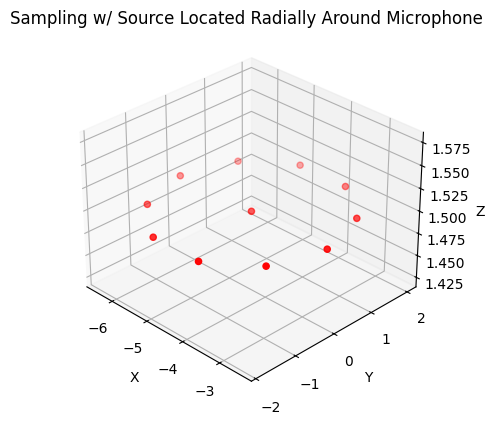

In [106]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

source_positions = np.genfromtxt('IR_wavs/source_positions.csv', delimiter=',', skip_header=1)

x = source_positions[:, 1]
y = source_positions[:, 2]
z = source_positions[:, 3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, marker='o', color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Sampling w/ Source Located Radially Around Microphone')

ax.view_init(elev=30, azim=-45)

plt.show()